In [1]:
%%capture
!python -m pip install git+https://github.com/huggingface/transformers gradio

In [2]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from transformers import Qwen2VLProcessor, Qwen2VLModel
from PIL import Image, ImageEnhance  
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import gradio as gr

In [3]:
model_name="/kaggle/input/qwen2-vl/transformers/7b-instruct/1"
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto",
)

processor = AutoProcessor.from_pretrained( model_name)


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

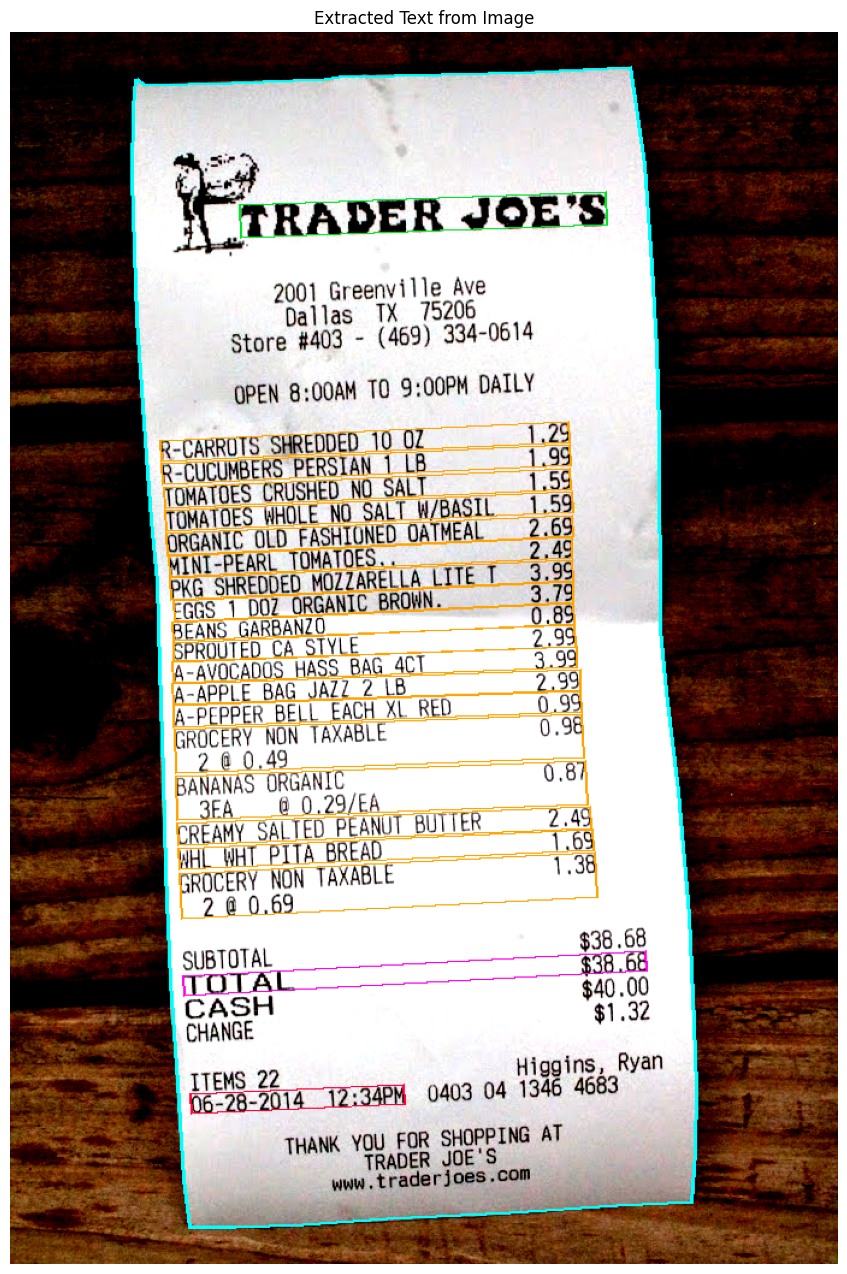

Extracted Text: system
You are a helpful assistant.
user
Extract all the text in this image.
assistant
TRADER JOE'S
2001 Greenville Ave
Dallas TX 75206
Store #403 - (469) 334-0614

OPEN 8:00AM TO 9:00PM DAILY

R-CARROTSES SHREDDED 10 OZ 1.29
R-CUCUMBERS PERSIAN 1 LB 1.99
TOMATOES CRUSHED NO SALT 1.59
TOMATOES WHOLE NO SALT W/BASIL 1.59
ORGANIC OLD FASHIONED OATMEAL 2.69
MINIPEARL TOMATOES... 2.49
PKG SHREDDED MOZZARELLA LITE T 3.95
EGGS 1 DOZ ORGANIC BROWN. 3.79
BEANS GARBANNOO 0.89
SPROUTED CA STYLE 2.99
A-AVOCADOS HASS BAG 4CT 3.99
A-APPLE BAG JAZZ 2 LB 2.99
A-PEPPER BELL EACH XL RED 0.99
GROCERY NON TAXABLE 0.98
2 @ 0.49
BANANAS ORGANIC 0.87
3EA @ 0.29/EA
CREAMY SALTED PEANUT BUTTER 2.49
WHL WHIT PITA BREAD 1.69
GROCERY NON TAXABLE 1.36
2 @ 0.69

SUBTOTAL $38.68
TOTAL $38.68
CASH $40.00
CHANGE $1.32

ITEMS 22
06-28-2014 12:34PM 0403 04 1346 4683

THANK YOU FOR SHOPPING AT
TRADER JOE'S
www.traderjoes.com


In [4]:
""" Enhance an image, extract text using the Qwen-2VL processor,
   and display both the image and the extracted text
"""

image_path = "/kaggle/input/ocr-receipts-text-detection/boxes/1.png"
image = Image.open(image_path)
image = ImageEnhance.Contrast(image).enhance(2.0).convert("RGB")


messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Extract all the text in this image."}
        ]
    }
]

inputs = processor(
    text=processor.apply_chat_template(messages, add_generation_prompt=True),
    images=[image],
    padding=True,
    return_tensors="pt"
)
inputs = inputs.to("cuda")

output_ids = model.generate(**inputs, max_new_tokens=1024)


extracted_text = processor.batch_decode(
    output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]


plt.figure(figsize=(16, 16))
plt.imshow(image)
plt.axis("off")
plt.title("Extracted Text from Image")
plt.show()

print("Extracted Text:", extracted_text)


### =======================

### *Try with Gradio*

In [5]:
custom_css = """
body {
    background-color: #2a2a40; /* Slightly lighter background for content area */;
    color: white;
}
.gradio-container {
    background-color:#2a2a40; /* Slightly lighter background for content area */;
    color: white;
}
/* Style input elements */
input[type="file"], textarea, input[type="text"] {
    background-color: #3a3a50;
    color: #000000; /* Black text */
    border: 1px solid #4a4a60;
    border-radius: 5px;
    padding: 10px;
    font-size: 14px;
    width: 100%;
    margin-bottom: 15px;
}
/* Style buttons */
button {
    background-color: #4caf50; /* Green button */
    color: #ffffff;
    border: none;
    padding: 10px 20px;
    font-size: 16px;
    border-radius: 5px;
    cursor: pointer;
    transition: background-color 0.3s ease;
}
/* Change the title color */
h1 {
    color: gray; /* Bright orange color */
    text-align: center; /* Optional: Center the title */
    font-size: 1.5em; /* Optional: Adjust the font size */
    font-family: 'Arial', sans-serif; /* Optional: Set a custom font */
    margin-bottom: 20px; /* Add spacing below the title */
}
p {
    color: white; 
    font-size: 1.2em; /* Adjust the font size */
    font-family: 'Arial', serif; /* Optional: A different font */
}
"""

In [6]:

def process_image(image_path_or_url):
    
    if image_path_or_url.startswith("http"):    
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path_or_url)


    image = ImageEnhance.Contrast(image).enhance(2.0).convert("RGB")
    
   
    messages = [            
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": "Extract all the text in this image."}
            ]
        }
    ]
    
  
    inputs = processor(
        text=processor.apply_chat_template(messages, add_generation_prompt=True),
        images=[image],
        padding=True,
        return_tensors="pt"
    )
    inputs = inputs.to("cuda")
    
  
    output_ids = model.generate(**inputs, max_new_tokens=1024)
    
    extracted_text = processor.batch_decode(
        output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True )[0] 

    return image, extracted_text

def gradio_interface(image=None, url=None):
    
    if url:
        input_source = url
    elif image:
        input_source = image.name  
    else:
        return None, "Please provide either an image or a URL."

  
    enhanced_image, extracted_text = process_image(input_source)
    
    enhanced_image_path = "enhanced_image.jpg"
    enhanced_image.save(enhanced_image_path)      # Save the enhanced image for display in Gradio
    
    return enhanced_image_path, extracted_text


interface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Image(type="filepath", label="Upload Image (optional)"),
        gr.Textbox(label="Image URL (optional)", placeholder="Enter an image URL")
    ],
    outputs=[
        gr.Image(type="filepath", label="Enhanced Image"),
        gr.Textbox(label="Extracted Text")
    ],
    title="OCR with Qwen-2VL",
    description="Upload an image or provide an image URL to extract text using Qwen-2VL and view the enhanced image.",
    css=custom_css

)               

interface.launch()


* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://c145c1df75f251b20b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
